# Step 1 - Frame Dividing Part

#### Install Opencv for Frame Extraction

In [ ]:
pip install opencv-python-headless

#### Importing Libraries CV2 and OS

In [ ]:
import cv2
import os

#### Function to Extract Frames

In [1]:
def extract_frames(video_path, output_folder, frame_rate=30):
    """Extract frames from a video at a given frame rate."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))  # Get video FPS

    # Debug: Print FPS
    print(f"Video: {video_path}, FPS: {fps}")

    if fps == 0:
        print("Error: Could not read FPS. Check the video file or codec.")
        return  # Exit function to prevent division by zero

    frame_interval = max(1, int(fps / frame_rate))  # Avoid division by zero

    count = 0
    frame_id = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Stop when the video ends

        if count % frame_interval == 0:
            frame_filename = os.path.join(output_folder, f"frame_{frame_id:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
            frame_id += 1  # Increment frame number

        count += 1

    cap.release()
    print(f" Extracted {frame_id} frames from {video_path}")


#### Check the orientation and Quality -Rotate if needed Automatically

In [4]:
import cv2
import os

def check_orientation(folder_path):
    """
    Automatically rotates portrait images in the given folder to landscape.
    Overwrites the original image if rotated.
    """
    for img_name in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"⚠️ Skipping unreadable image: {img_name}")
            continue

        height, width, _ = img.shape

        # Rotate only if it's in portrait orientation
        if height > width:
            img_rotated = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
            cv2.imwrite(img_path, img_rotated)
            print(f"🔄 Rotated {img_name} to landscape ({height}x{width}) → ({img_rotated.shape[1]}x{img_rotated.shape[0]})")
        else:
            print(f"✅ {img_name} already landscape ({width}x{height})")


#### Remove Blurry Images from frames

In [ ]:
import os
import cv2
import shutil

def detect_and_move_blurry_images(folder_path, default_threshold=120.0):
    """
    Analyze blurriness of images using Laplacian variance.
    Prompts for threshold input and moves blurry images to a separate folder.
    """
    print(f"\n🔍 Analyzing blurriness in: {folder_path}")
    blur_data = []

    # Step 1: Collect and show blurriness variance
    for img_name in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ Skipping unreadable image: {img_name}")
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        variance = cv2.Laplacian(gray, cv2.CV_64F).var()
        blur_data.append((img_name, variance))

    # Display all variance scores
    print("\n📊 Blurriness Index (Higher is sharper):")
    for name, var in blur_data:
        print(f"{name}: Variance = {var:.2f}")

    # Step 2: Ask user for threshold
    try:
        threshold_input = input(f"\nEnter blurriness threshold [Default = {default_threshold}]: ")
        threshold = float(threshold_input) if threshold_input.strip() else default_threshold
    except ValueError:
        print("⚠️ Invalid input. Using default threshold.")
        threshold = default_threshold

    # Step 3: Move blurry images
    blurry_folder = os.path.join(os.path.dirname(folder_path), f"blurry_{os.path.basename(folder_path)}")
    os.makedirs(blurry_folder, exist_ok=True)

    moved = 0
    for name, var in blur_data:
        if var < threshold:
            src_path = os.path.join(folder_path, name)
            dst_path = os.path.join(blurry_folder, name)
            shutil.move(src_path, dst_path)
            print(f"📁 Moved blurry image: {name} (Variance = {var:.2f})")
            moved += 1

    print(f"\n✅ Done. {moved} blurry images moved to '{blurry_folder}'.")

# Example usage
# detect_and_move_blurry_images("Output/extracted_frames/top")


# Step 2 - Extracting Key points

#### Install mediapipe

In [ ]:
pip install mediapipe


#### Detect Keypoints - Annotate the Frames

In [2]:
import cv2
import mediapipe as mp
import os

# Initialize MediaPipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

def detect_keypoints(input_folder, output_folder):
    """Detects keypoints in images and saves annotated frames."""
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for img_name in sorted(os.listdir(input_folder)):
        img_path = os.path.join(input_folder, img_name)
        image = cv2.imread(img_path)

        if image is None:
            continue  # Skip if image is corrupted

        # Convert BGR to RGB (MediaPipe expects RGB)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb_image)

        if results.pose_landmarks:
            # Draw keypoints on the image
            mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Save the output image
        output_path = os.path.join(output_folder, img_name)
        cv2.imwrite(output_path, image)

    print(f"✅ Keypoint detection completed. Output saved in {output_folder}")



#### Extract 2D Key Point Data into Json

In [3]:
import cv2
import mediapipe as mp
import os
import json

# Initialize MediaPipe Pose model
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

def extract_2d_keypoints(input_folder, output_json):
    """Extracts 2D keypoints from images and saves them to a JSON file."""
    keypoints_data = {}

    for img_name in sorted(os.listdir(input_folder)):  # Process frames in order
        img_path = os.path.join(input_folder, img_name)
        image = cv2.imread(img_path)

        if image is None:
            continue  # Skip if image is corrupted

        # Convert BGR to RGB (MediaPipe expects RGB)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb_image)

        frame_keypoints = []
        if results.pose_landmarks:
            for landmark in results.pose_landmarks.landmark:
                frame_keypoints.append((landmark.x, landmark.y))  # Store (x, y) only

        keypoints_data[img_name] = frame_keypoints  # Store keypoints for this frame

    # Save results to JSON
    with open(output_json, 'w') as f:
        json.dump(keypoints_data, f, indent=4)

    print(f"✅ 2D keypoints extracted and saved to {output_json}")



#### Normalize the data

- No need Because MediaPipe Already Normalize

#### Pose Completness Check

In [7]:
import cv2
import mediapipe as mp
import os
import shutil

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

def check_pose_completeness_and_move(input_folder, bad_folder, min_visible=25, visibility_threshold=0.5):
    """
    Checks pose completeness and moves frames with low keypoint visibility to a separate folder.
    """
    if not os.path.exists(bad_folder):
        os.makedirs(bad_folder)

    print(f"🔍 Checking pose completeness in: {input_folder}")
    incomplete_frames = []

    for img_name in sorted(os.listdir(input_folder)):
        img_path = os.path.join(input_folder, img_name)
        image = cv2.imread(img_path)

        if image is None:
            continue

        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb_image)

        visible_count = 0
        if results.pose_landmarks:
            for landmark in results.pose_landmarks.landmark:
                if landmark.visibility >= visibility_threshold:
                    visible_count += 1

        if visible_count < min_visible:
            incomplete_frames.append((img_name, visible_count))
            print(f"⚠️ Incomplete pose in {img_name}: {visible_count}/33 visible")

            # Move the bad frame
            shutil.move(img_path, os.path.join(bad_folder, img_name))

    print(f"\n📉 Moved {len(incomplete_frames)} incomplete frames to '{bad_folder}'")
    return incomplete_frames


In [ ]:
# Move bad top-view frames
check_pose_completeness_and_move(
    input_folder="Output Video/frames/top",
    bad_folder="Output Video/frames/top_bad"
)

# You can run it for front or side too
# check_pose_completeness_and_move("Output Video/frames/front", "Output Video/frames/front_bad")


#### Visualize Annotations

In [8]:
import matplotlib.pyplot as plt

# Load the image
image = plt.imread("Output Video/frames/front/frame_0000.jpg")
height, width, _ = image.shape

# Convert normalized keypoints to pixel values
x_pixels = [x * width for x, y in keypoints]
y_pixels = [y * height for x, y in keypoints]

# Display image and overlay points
plt.imshow(image)
plt.scatter(x_pixels, y_pixels, c="red", marker="o")  # Red dots for keypoints
plt.title("MediaPipe Pose Annotations")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Output Video/frames/front/frame_0000.jpg'

#### Manually Update Annoatations

In [ ]:
import cv2
import numpy as np

image_path = "Output Video/frames/front/frame_0000.jpg"
image = cv2.imread(image_path)
height, width, _ = image.shape

# Replace with your actual keypoints (normalized)
keypoints = [
        [
            0.5505455732345581,
            0.5588361024856567
        ],
        [
            0.5572452545166016,
            0.552212119102478
        ],
        [
            0.5614649653434753,
            0.5519828200340271
        ],
        [
            0.5650237202644348,
            0.5518215894699097
        ],
        [
            0.5457234382629395,
            0.5524178743362427
        ],
        [
            0.542575478553772,
            0.5522381067276001
        ],
        [
            0.5397322773933411,
            0.5520192980766296
        ],
        [
            0.5709152817726135,
            0.551386833190918
        ],
        [
            0.5365363359451294,
            0.5507765412330627
        ],
        [
            0.5573853850364685,
            0.5633068680763245
        ],
        [
            0.5449458360671997,
            0.5633752346038818
        ],
        [
            0.6019920110702515,
            0.5733140110969543
        ],
        [
            0.5090041756629944,
            0.5722963213920593
        ],
        [
            0.6641108989715576,
            0.5980207920074463
        ],
        [
            0.4531230330467224,
            0.5994670391082764
        ],
        [
            0.6960875988006592,
            0.6336801648139954
        ],
        [
            0.4205382168292999,
            0.6375626921653748
        ],
        [
            0.7118327617645264,
            0.6432164907455444
        ],
        [
            0.410492867231369,
            0.6457881331443787
        ],
        [
            0.7016799449920654,
            0.6457731127738953
        ],
        [
            0.42393040657043457,
            0.6460126042366028
        ],
        [
            0.6945846676826477,
            0.6432654857635498
        ],
        [
            0.42746487259864807,
            0.6433942914009094
        ],
        [
            0.5882201790809631,
            0.6286242008209229
        ],
        [
            0.5343642830848694,
            0.6304098963737488
        ],
        [
            0.6483628749847412,
            0.6160215735435486
        ],
        [
            0.46625185012817383,
            0.6172221899032593
        ],
        [
            0.6089972853660583,
            0.656097948551178
        ],
        [
            0.5100529193878174,
            0.6553679704666138
        ],
        [
            0.6025288105010986,
            0.6603747606277466
        ],
        [
            0.518900454044342,
            0.658387303352356
        ],
        [
            0.6210933923721313,
            0.6730417609214783
        ],
        [
            0.47687360644340515,
            0.6730539202690125
        ]
    ]

# Convert to pixel coordinates
keypoints_px = [(int(x * width), int(y * height)) for x, y in keypoints]

# For dragging
dragging = False
drag_index = -1
undo_stack = []

def draw_points(img, points):
    for i, (x, y) in enumerate(points):
        cv2.circle(img, (x, y), 5, (0, 255, 0), -1)
        cv2.putText(img, str(i), (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 1)

def get_nearest_point(x, y, points, radius=10):
    for i, (px, py) in enumerate(points):
        if abs(px - x) <= radius and abs(py - y) <= radius:
            return i
    return -1

def mouse_callback(event, x, y, flags, param):
    global dragging, drag_index, keypoints_px, undo_stack

    if event == cv2.EVENT_LBUTTONDOWN:
        idx = get_nearest_point(x, y, keypoints_px)
        if idx != -1:
            dragging = True
            drag_index = idx
            undo_stack.append(keypoints_px.copy())  # Save previous state
    elif event == cv2.EVENT_MOUSEMOVE:
        if dragging and drag_index != -1:
            keypoints_px[drag_index] = (x, y)
    elif event == cv2.EVENT_LBUTTONUP:
        dragging = False
        drag_index = -1

cv2.namedWindow("Adjust Keypoints", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Adjust Keypoints", 640, 480)
cv2.setMouseCallback("Adjust Keypoints", mouse_callback)

while True:
    temp_image = image.copy()
    draw_points(temp_image, keypoints_px)
    cv2.imshow("Adjust Keypoints", temp_image)
    key = cv2.waitKey(1)

    if key == ord('q'):  # Quit and save
        break
    elif key == ord('u'):  # Undo
        if undo_stack:
            keypoints_px = undo_stack.pop()
            print("Undo last move.")

cv2.destroyAllWindows()

# Convert to normalized keypoints
updated_keypoints = [[x / width, y / height] for x, y in keypoints_px]
print("Updated normalized keypoints:")
for point in updated_keypoints:
    print(point)


#### Saving Image MetaData

In [ ]:
import os
import cv2
import json

def store_frame_metadata(image_folder, output_metadata_json):
    """
    Stores metadata (filename, resolution, etc.) for annotated frames in a JSON file.
    """
    metadata = {}

    for img_name in sorted(os.listdir(image_folder)):
        img_path = os.path.join(image_folder, img_name)
        image = cv2.imread(img_path)

        if image is None:
            continue

        height, width, channels = image.shape
        metadata[img_name] = {
            "resolution": f"{width}x{height}",
            "width": width,
            "height": height,
            "channels": channels,
            "path": img_path
            # You can add more info here like timestamp if available
        }

    # Save metadata to JSON
    with open(output_metadata_json, 'w') as f:
        json.dump(metadata, f, indent=4)

    print(f"📝 Metadata saved to {output_metadata_json}")


In [ ]:
store_frame_metadata("Output Video/keypoints/front", "Output Video/keypoints/front_metadata.json")
store_frame_metadata("Output Video/keypoints/side", "Output Video/keypoints/side_metadata.json")
store_frame_metadata("Output Video/keypoints/top", "Output Video/keypoints/top_metadata.json")


# Step 3 - Feature Extraction using Media Pipe

#### Get Angles from Keypoints

In [4]:
import numpy as np
import json
import os

def calculate_angle(a, b, c):
    a, b, c = np.array(a), np.array(b), np.array(c)
    ba, bc = a - b, c - b
    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    return np.degrees(np.arccos(np.clip(cosine_angle, -1.0, 1.0)))

POSE_LANDMARKS = {
    "front": {
        "right_shoulder": 12, "right_elbow": 14, "right_wrist": 16,
        "left_shoulder": 11, "left_elbow": 13, "left_wrist": 15
    },
    "side": {
        "shoulder": 12, "elbow": 14, "wrist": 16,
        "hip": 24, "knee": 26, "ankle": 28,
        "back": 11, "foot": 32
    },
    "top": {
        "left_shoulder": 11, "right_shoulder": 12,
        "left_hip": 23, "right_hip": 24,
        "left_wrist": 15, "right_wrist": 16
    }
}

def get_view_from_path(path):
    folder_name = os.path.basename(os.path.dirname(path)).lower()
    if "front" in folder_name:
        return "front"
    elif "side" in folder_name:
        return "side"
    elif "top" in folder_name:
        return "top"
    return "unknown"

def extract_joint_angles(input_path, output_path):
    view = get_view_from_path(input_path)
    if view == "unknown":
        print(f"⚠️ Skipping: Unknown view in path: {input_path}")
        return

    with open(input_path, "r") as file:
        keypoints_data = json.load(file)

    landmarks = POSE_LANDMARKS[view]
    angles_per_frame = {}

    for frame_name, keypoints in keypoints_data.items():
        angles = {}

        def get_landmark(name):
            index = landmarks.get(name)
            if index is None or index >= len(keypoints):
                return None
            return keypoints[index]

        if view == "front":
            r_s, r_e, r_w = get_landmark("right_shoulder"), get_landmark("right_elbow"), get_landmark("right_wrist")
            l_s, l_e, l_w = get_landmark("left_shoulder"), get_landmark("left_elbow"), get_landmark("left_wrist")
            if None not in [r_s, r_e, r_w]:
                angles["right_elbow_angle"] = calculate_angle(r_s, r_e, r_w)
            if None not in [l_s, l_e, l_w]:
                angles["left_elbow_angle"] = calculate_angle(l_s, l_e, l_w)

        elif view == "side":
            s, e, w = get_landmark("shoulder"), get_landmark("elbow"), get_landmark("wrist")
            h, k, a = get_landmark("hip"), get_landmark("knee"), get_landmark("ankle")
            b, f = get_landmark("back"), get_landmark("foot")
            if None not in [h, k, a]:
                angles["knee_angle"] = calculate_angle(h, k, a)
            if None not in [s, h, k]:
                angles["hip_angle"] = calculate_angle(s, h, k)
            if None not in [k, a, f]:
                angles["ankle_angle"] = calculate_angle(k, a, f)
            if None not in [s, b, f]:
                angles["back_angle"] = calculate_angle(s, b, f)
            if None not in [s, e, w]:
                angles["elbow_angle"] = calculate_angle(s, e, w)

        elif view == "top":
            l_s, r_s = get_landmark("left_shoulder"), get_landmark("right_shoulder")
            l_h, r_h = get_landmark("left_hip"), get_landmark("right_hip")
            l_w, r_w = get_landmark("left_wrist"), get_landmark("right_wrist")
            if None not in [l_s, r_s, r_h]:
                angles["shoulder_symmetry"] = calculate_angle(l_s, r_s, r_h)
            if None not in [l_h, r_h, r_s]:
                angles["hip_symmetry"] = calculate_angle(l_h, r_h, r_s)
            if None not in [l_w, r_w, r_s]:
                angles["wrist_alignment"] = calculate_angle(l_w, r_w, r_s)

        if angles:
            angles_per_frame[frame_name] = angles

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    with open(output_path, "w") as f:
        json.dump(angles_per_frame, f, indent=4)
    print(f"✅ Saved joint angles to {output_path}")


# Step 4 - Creating Dataset

#### Install Pandas

In [ ]:
pip install pandas

#### Creating Dataset for GRU regression - This will be used in Automatic pipeline

In [5]:
import json
import numpy as np
import os

# Set of processed players to avoid duplicates
processed_players = set()

# Feedback categories mapped to model output vector
FEEDBACK_CATEGORIES = [
    "back_angle_correction",
    "knee_angle_correction",
    "shoulder_symmetry_correction",
    "hip_symmetry_correction",
    "elbow_angle_correction"
]

# Target optimal values for feedback (domain-specific)
TARGETS = {
    "back_angle": 30,
    "knee_angle": 60,
    "shoulder_symmetry": 180,
    "hip_symmetry": 180,
    "elbow_angle": 160
}

def generate_feedback_continuous(avg_features):
    """Generates continuous feedback values as the difference from optimal angles."""
    return {
        category: TARGETS[category.replace("_correction", "")] - avg_features[category.replace("_correction", "")]
        for category in FEEDBACK_CATEGORIES
    }


# Step 5 - Model Architecture Designing and Training

#### Sklearn Install

In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


#### Tenserflow install

In [2]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


#### GRU Regression Model Train

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# === Load the regression dataset from .npz ===
data = np.load("regression_dataset_snatch.npz")
X = data["X"]  # shape: (samples, seq_len, features)
y = data["y"]  # shape: (samples, feedback categories)
t = data["t"]  # shape: (samples,)

# === Train-validation split ===
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# === Define GRU regression model ===
def build_gru_regression_model(input_shape):
    model = Sequential()
    model.add(GRU(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(y.shape[1], activation='linear'))  # Linear output for regression
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mean_absolute_error'])
    return model

# === Build model ===
input_shape = (X_train.shape[1], X_train.shape[2])  # (seq_len, features)
model = build_gru_regression_model(input_shape)

# === Train model ===
history = model.fit(X_train, y_train, epochs=250, batch_size=32, validation_data=(X_val, y_val))

# === Save model ===
model.save("gru_posture_model_snatch_regression.h5")

# === Print training history ===
print("✅ Training complete!")
print(history.history)


Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 5683.4727 - mean_absolute_error: 64.8140 - val_loss: 5589.7329 - val_mean_absolute_error: 64.7871
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 5609.8442 - mean_absolute_error: 64.3073 - val_loss: 5573.6035 - val_mean_absolute_error: 64.7005
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5576.4966 - mean_absolute_error: 64.4214 - val_loss: 5563.1284 - val_mean_absolute_error: 64.6351
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5558.8091 - mean_absolute_error: 64.1867 - val_loss: 5552.5029 - val_mean_absolute_error: 64.5768
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 5479.6895 - mean_absolute_error: 63.6538 - val_loss: 5549.0239 - val_mean_absolute_error: 64.5671
Epoch 6/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 5474.7485 - mean_absolute_error: 63.7230 - val_loss: 5532.9844 - val_mean_absolute_error: 64.5030
Epoch 7/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5571.

✅ Training complete!
{'loss': [5623.2392578125, 5607.47509765625, 5587.8759765625, 5578.4326171875, 5556.970703125, 5537.859375, 5520.3984375, 5507.90185546875, 5490.3955078125, 5465.77978515625, 5454.31396484375, 5438.2275390625, 5416.4755859375, 5396.654296875, 5396.5205078125, 5377.89990234375, 5354.107421875, 5334.86962890625, 5326.9306640625, 5304.2158203125, 5289.1962890625, 5280.0908203125, 5252.6064453125, 5222.4990234375, 5219.8896484375, 5199.64453125, 5176.8740234375, 5149.1171875, 5139.26171875, 5117.3681640625, 5102.06298828125, 5069.42578125, 5050.21826171875, 5032.7294921875, 5038.7900390625, 4976.82080078125, 4989.51318359375, 4931.5478515625, 4891.98388671875, 4878.14111328125, 4885.111328125, 4833.279296875, 4807.18359375, 4765.9658203125, 4726.28173828125, 4719.09033203125, 4652.2744140625, 4631.63623046875, 4617.47509765625, 4577.64990234375, 4551.1572265625, 4484.97216796875, 4450.171875, 4430.62939453125, 4401.12939453125, 4318.65771484375, 4290.205078125, 4296.71

#### Plot the Metrics

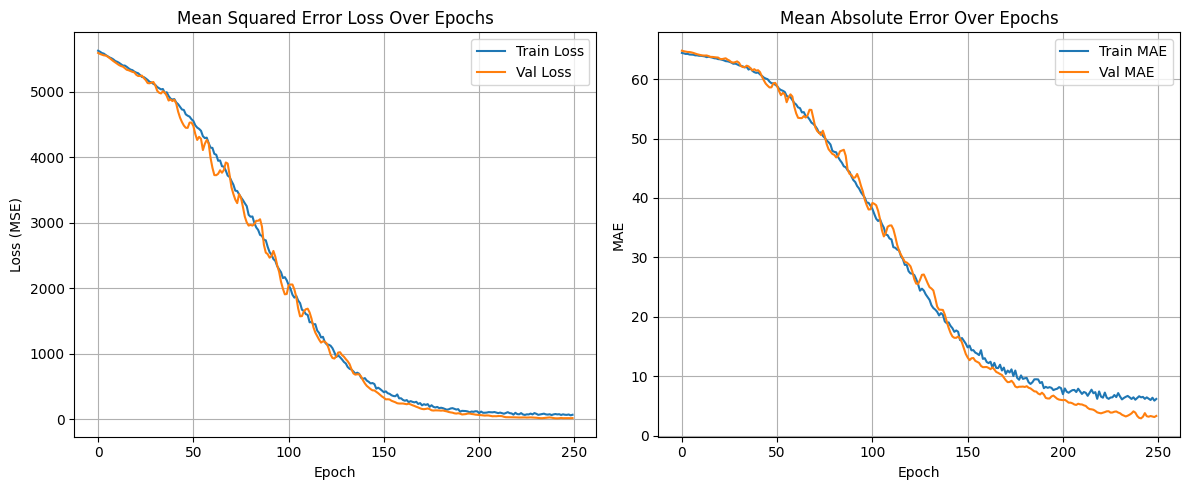

In [27]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Mean Squared Error Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)

# Plot MAE
plt.subplot(1, 2, 2)
plt.plot(history.history["mean_absolute_error"], label="Train MAE")
plt.plot(history.history["val_mean_absolute_error"], label="Val MAE")
plt.title("Mean Absolute Error Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


##### Metrics

In [28]:
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
print(f"📉 Validation Loss (MSE): {val_loss:.4f}")
print(f"📈 Validation MAE: {val_mae:.4f}")


📉 Validation Loss (MSE): 17.3906
📈 Validation MAE: 3.3077


## Using Model

#### Load Saved Model

In [6]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model("gru_posture_model_snatch_regression.h5")


In [7]:
data = np.load("regression_dataset_snatch.npz")
X_test = data["X"]
y_test = data["y"]  # optional, if you want to compare

# Predict for all samples
y_pred = model.predict(X_test)

# Example: Compare first prediction with ground truth
print("Predicted:", y_pred[0])
print("Actual   :", y_test[0])


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Predicted: [ 0.04028483  3.4688342  -0.9196923   1.7480456  -0.21574661]
Actual   : [-40.83803125   4.00943148  84.4181457   97.9865693   -1.17797459]


# Automatic Pipeline function

In [8]:
import os
import cv2
import json
import csv
from datetime import datetime

# ======================= #
# ==== CONFIGURATION ==== #
# ======================= #

# Hardcoded output paths for consistency
FRAMES_ROOT = "Output/frames"
KEYPOINTS_ROOT = "Output/keypoints"
ANNOTATIONS_ROOT = "Output/annotations"
LOG_FILE = "Output/processing_log.txt"
CENTRAL_INDEX_FILE = "Output/central_index.csv"


# Features to extract from the video

ANGLES_ROOT = "Output/angles"

# Create all required output folders at startup
for path in [FRAMES_ROOT, KEYPOINTS_ROOT, ANNOTATIONS_ROOT, ANGLES_ROOT, os.path.dirname(LOG_FILE)]:
    os.makedirs(path, exist_ok=True)

# =============================== #
# ==== UTILITY HELPER FUNCS ==== #
# =============================== #

# This function retrieves all video files from the specified root folder and its subdirectories.
## It supports multiple file extensions (e.g., .mp4, .mov) and returns a list of full paths.
def get_all_video_paths(root_folder, extensions=(".mp4", ".mov")):
    video_paths = []
    for dirpath, _, filenames in os.walk(root_folder):
        for file in filenames:
            if file.lower().endswith(extensions):
                video_paths.append(os.path.join(dirpath, file))
    return video_paths


# This function generates a relative path for a video file based on the root input folder.
def get_relative_path(video_path, root_folder):
    return os.path.relpath(video_path, root_folder)

# This function builds output paths for frames, keypoints, annotations, and metadata based on the video path.
# It uses the relative path to create a consistent structure under the defined output folders.
def build_output_paths(video_path, root_input_folder):
    relative_path = get_relative_path(video_path, root_input_folder)
    base = os.path.splitext(relative_path)[0]
    return {
        "frames": os.path.join(FRAMES_ROOT, base),
        "keypoints": os.path.join(KEYPOINTS_ROOT, base),
        "annotations": os.path.join(ANNOTATIONS_ROOT, base),
        "metadata": os.path.join(KEYPOINTS_ROOT, base, "metadata.json"),
        "angles": os.path.join(ANGLES_ROOT, base)  #features
    }

# This function checks if a video has already been processed by looking for the metadata file.
# If the metadata file exists, it indicates that the video has been processed.
def has_been_processed(paths):
    return os.path.exists(paths["metadata"])

# This function logs messages to a log file and prints them to the console.
# It includes a timestamp for each message.
def log_message(message):
    timestamp = f"{datetime.now()} - {message}"
    os.makedirs(os.path.dirname(LOG_FILE), exist_ok=True)
    with open(LOG_FILE, "a", encoding="utf-8") as log_file:
        log_file.write(timestamp + "\n")
    print(timestamp)

# This function saves metadata about the processed video to a JSON file.
# It includes the video path, processing time, and paths to frames and keypoints.
def save_metadata(metadata_path, data):
    os.makedirs(os.path.dirname(metadata_path), exist_ok=True)
    with open(metadata_path, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4)

# This function updates a central index CSV file with metadata about processed videos.
# It appends a new row with the video path, frame folder, keypoints folder, annotation folder, and processing time.
def update_central_index(index_file, row):
    os.makedirs(os.path.dirname(index_file), exist_ok=True)
    file_exists = os.path.exists(index_file)
    with open(index_file, "a", newline="", encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=row.keys())
        if not file_exists:
            writer.writeheader()
        writer.writerow(row)

# ===================================== #
# ==== MAIN VIDEO PROCESSOR FUNC  ==== #
# ===================================== #

def process_all_videos(root_input_folder):
    """
    Main function to process all videos in the specified root input folder.
    It extracts frames, detects keypoints, and saves metadata.
    """
    
    # Get all video paths from the root input folder
    videos = get_all_video_paths(root_input_folder)
    # If no videos found, log and exit
    log_message(f"🎬 Found {len(videos)} videos under '{root_input_folder}'")

    # If no videos found, exit early
    for video_path in videos:
        paths = build_output_paths(video_path, root_input_folder)
        if has_been_processed(paths):
            log_message(f"⏭️ Skipping already processed: {video_path}")
            continue

        # Create required output folders
        for key in ["frames", "keypoints", "annotations", "angles"]:
            os.makedirs(paths[key], exist_ok=True)

        try:
            # ====== MAIN PIPELINE STEPS ======
            # ====== Adjust these steps as needed ======
            
            # STEP 1: Extract frames from the video
            extract_frames(video_path, paths["frames"])  # ok no problem

            # STEP 2: Detect keypoints in the frames
            detect_keypoints(paths["frames"], paths["annotations"])  # ok not problem
            
            # STEP 3: Extract 2D keypoints from the annotated frames
            extract_2d_keypoints(paths["frames"], os.path.join(paths["keypoints"], "keypoints.json"))  # ok
            
            # STEP 4: Extract joint angles from keypoints
            extract_joint_angles(os.path.join(paths["keypoints"], "keypoints.json"), os.path.join(paths["angles"], "joint_angles.json"))  # STEP 4


            # ====== End of processing steps ======
            
            # ====== Save metadata ======
            metadata = {
                "video": video_path,
                "processed_at": str(datetime.now()),
                "frames_folder": paths["frames"],
                "keypoints_json": os.path.join(paths["keypoints"], "keypoints.json")
            }
            save_metadata(paths["metadata"], metadata)

            # ====== Update tracking CSV ======
            update_central_index(CENTRAL_INDEX_FILE, {
                "video_path": video_path,
                "frames_folder": paths["frames"],
                "keypoints_folder": paths["keypoints"],
                "annotation_folder": paths["annotations"],
                "processed_at": metadata["processed_at"]
            })

            log_message(f"✅ Processed: {video_path}")

        except Exception as e:
            log_message(f"❌ Error processing {video_path}: {str(e)}")


In [9]:
process_all_videos("Source")

2025-06-15 16:13:41.256620 - 🎬 Found 62 videos under 'Source'
Video: Source\Player 2\CP\Player02_CP_Set_01\Player02_CP_60Kg_front_view.MOV, FPS: 60
 Extracted 206 frames from Source\Player 2\CP\Player02_CP_Set_01\Player02_CP_60Kg_front_view.MOV
✅ Keypoint detection completed. Output saved in Output/annotations\Player 2\CP\Player02_CP_Set_01\Player02_CP_60Kg_front_view
✅ 2D keypoints extracted and saved to Output/keypoints\Player 2\CP\Player02_CP_Set_01\Player02_CP_60Kg_front_view\keypoints.json
✅ Saved joint angles to Output/angles\Player 2\CP\Player02_CP_Set_01\Player02_CP_60Kg_front_view\joint_angles.json
2025-06-15 16:14:37.717780 - ✅ Processed: Source\Player 2\CP\Player02_CP_Set_01\Player02_CP_60Kg_front_view.MOV
Video: Source\Player 2\CP\Player02_CP_Set_01\Player02_CP_60Kg_side_view.MOV, FPS: 59
 Extracted 340 frames from Source\Player 2\CP\Player02_CP_Set_01\Player02_CP_60Kg_side_view.MOV
✅ Keypoint detection completed. Output saved in Output/annotations\Player 2\CP\Player02_CP_S

# Creating Dataset Scanning Joint Angles from All files

#### Find Triplets for the json file (Front ,Side,Top) and Verify

In [10]:
import os
from collections import defaultdict

def find_joint_angle_triplets(root_dir):
    # Dictionary to hold grouped paths for each recording based on base name
    # Format: { base_name: { "front": path, "side": path, "top": path } }
    triplet_groups = defaultdict(dict)

    # Walk through the directory tree
    for root, dirs, files in os.walk(root_dir):
        # Check if this directory contains a joint_angles.json file
        if "joint_angles.json" in files:
            view_type = None

            # Identify view type based on folder name
            if "front_view" in root:
                view_type = "front"
            elif "side_view" in root:
                view_type = "side"
            elif "top_view" in root:
                view_type = "top"

            if view_type:
                # Get the name of the immediate directory (e.g., "lift1_front_view")
                parent = os.path.basename(root)

                # Remove the view-specific suffix to get the base name (e.g., "lift1")
                base_name = parent.replace("_front_view", "").replace("_side_view", "").replace("_top_view", "")

                # Store the full path to joint_angles.json under the appropriate view
                triplet_groups[base_name][view_type] = os.path.join(root, "joint_angles.json")

    # Collect only those entries that have all three views
    triplets = []
    for base, views in triplet_groups.items():
        if all(v in views for v in ["front", "side", "top"]):
            triplets.append((views["front"], views["side"], views["top"]))

    # Print how many complete triplets were found
    print(f"✅ Found {len(triplets)} complete joint angle triplets.")
    
    return triplets  # Return list of (front, side, top) file paths


In [12]:
triplets = find_joint_angle_triplets("Output/angles")
for front, side, top in triplets:
    print("Front:", front)
    print("Side:", side)
    print("Top :", top)
    print("---")


✅ Found 16 complete joint angle triplets.
Front: Output/angles\Player 2\CP\Player02_CP_Set_01\Player02_CP_60Kg_front_view\joint_angles.json
Side: Output/angles\Player 2\CP\Player02_CP_Set_01\Player02_CP_60Kg_side_view\joint_angles.json
Top : Output/angles\Player 2\CP\Player02_CP_Set_01\Player02_CP_60Kg_top_view\joint_angles.json
---
Front: Output/angles\Player 2\CP\Player02_CP_Set_02\Player02_CP_80Kg_front_view\joint_angles.json
Side: Output/angles\Player 2\CP\Player02_CP_Set_02\Player02_CP_80Kg_side_view\joint_angles.json
Top : Output/angles\Player 2\CP\Player02_CP_Set_02\Player02_CP_80Kg_top_view\joint_angles.json
---
Front: Output/angles\Player 2\CP\Player02_CP_Set_03\Player02_CP_90Kg_front_view\joint_angles.json
Side: Output/angles\Player 2\CP\Player02_CP_Set_03\Player02_CP_90Kg_side_view\joint_angles.json
Top : Output/angles\Player 2\CP\Player02_CP_Set_03\Player02_CP_90Kg_top_view\joint_angles.json
---
Front: Output/angles\Player 2\FCJ\Player02_FCJ_Set_01\Player02_FCJ_50Kg_front_v

#### Create Dataset -Feedback Genaration

In [13]:
import json

def process_joint_angle_triplet(front_path, side_path, top_path, seq_len=20):
    # Load JSON files for front, side, and top views
    with open(front_path, "r") as f: front_view = json.load(f)
    with open(side_path, "r") as f: side_view = json.load(f)
    with open(top_path, "r") as f: top_view = json.load(f)

    # Find the set of frame keys common to all three views
    common_frames = set(front_view.keys()) & set(side_view.keys()) & set(top_view.keys())

    # Sort the frames numerically by extracting digits from frame names (e.g., "frame001")
    sorted_frames = sorted(common_frames, key=lambda x: int(''.join(filter(str.isdigit, x))))

    # Initialize feature list (X), target list (y), and metadata list
    X, y, metadata = [], [], []

    # Loop over sequences of frames, with the window size = seq_len
    for i in range(len(sorted_frames) - seq_len + 1):
        sequence = []  # Holds features for the current sequence
        skip = False   # Flag to skip invalid sequences
        angle_sums = {k: 0 for k in TARGETS}  # Accumulate values for feedback calculation

        # Select a sequence of consecutive frames
        current_frames = sorted_frames[i:i + seq_len]

        # Extract features for each frame in the sequence
        for frame in current_frames:
            try:
                # Collect angles from all three views for this frame
                features = [
                    front_view[frame]["right_elbow_angle"],
                    front_view[frame]["left_elbow_angle"],
                    side_view[frame]["knee_angle"],
                    side_view[frame]["hip_angle"],
                    side_view[frame]["ankle_angle"],
                    side_view[frame]["back_angle"],
                    side_view[frame]["elbow_angle"],
                    top_view[frame]["shoulder_symmetry"],
                    top_view[frame]["hip_symmetry"],
                    top_view[frame]["wrist_alignment"]
                ]

                # Validate: skip the frame if any angle is out of expected range
                if any(not (0 <= val <= 180) for val in features):
                    raise ValueError("Invalid angle value")

                sequence.append(features)  # Add features to sequence

                # Update running totals for feedback-relevant features
                angle_sums["back_angle"] += features[5]
                angle_sums["knee_angle"] += features[2]
                angle_sums["shoulder_symmetry"] += features[7]
                angle_sums["hip_symmetry"] += features[8]
                angle_sums["elbow_angle"] += features[6]

            except Exception as e:
                # Skip the current sequence if any error occurs
                print(f"⚠️ Skipping sequence at frame {frame}: {e}")
                skip = True
                break

        if skip:
            continue  # Skip storing this sequence

        # Compute average feature values across the sequence for feedback
        avg_features = {k: v / seq_len for k, v in angle_sums.items()}

        # Generate feedback based on average values
        feedback = generate_feedback_continuous(avg_features)

        # Convert feedback dictionary to a fixed-length vector
        feedback_vector = [feedback[cat] for cat in FEEDBACK_CATEGORIES]

        # Append sequence and corresponding feedback vector to dataset
        X.append(sequence)
        y.append(feedback_vector)

        # Store additional metadata for analysis/debugging
        metadata.append({
            "frames_used": current_frames,
            "avg_features": avg_features,
            "feedback": feedback
        })

    return X, y, metadata  # Return processed data: sequences, labels, and metadata


#### Create Dataset - Automatic Iteration

In [15]:
import numpy as np
import os
import json

def extract_technique_from_path(path: str) -> str:
    # Example: path = .../angles/Player 2/CP/Player02_CP_Set_01/...
    parts = os.path.normpath(path).split(os.sep)
    try:
        technique_index = parts.index("angles") + 2  # 'angles' + 1 = Player, +2 = Technique
        return parts[technique_index]
    except (ValueError, IndexError):
        return "unknown"  # Fallback if structure is broken

def create_regression_dataset_from_folder_auto_tagged(
    angles_root: str,
    output_path: str = "regression_dataset.npz",
    metadata_log_path: str = "regression_metadata_log.json",
    seq_len: int = 20,
):
    all_X, all_y, all_t, all_metadata = [], [], [], []

    triplets = find_joint_angle_triplets(angles_root)
    print(f"🔍 Found {len(triplets)} triplets of joint_angles.json files.")

    for idx, (front_path, side_path, top_path) in enumerate(triplets):
        print(f"\n▶️ Processing triplet {idx+1}/{len(triplets)}")

        # Extract technique from front_path (they all share the same root structure)
        technique = extract_technique_from_path(front_path)

        try:
            X, y, metadata = process_joint_angle_triplet(front_path, side_path, top_path, seq_len=seq_len)

            all_X.extend(X)
            all_y.extend(y)
            all_t.extend([technique] * len(X))

            for m in metadata:
                m.update({
                    "front_path": front_path,
                    "side_path": side_path,
                    "top_path": top_path,
                    "sequence_index": metadata.index(m),
                    "technique": technique
                })
            all_metadata.extend(metadata)

        except Exception as e:
            print(f"❌ Failed processing triplet {idx+1}: {e}")
            continue

    # Convert to NumPy arrays and save
    all_X = np.array(all_X)
    all_y = np.array(all_y)
    all_t = np.array(all_t)

    np.savez(output_path, X=all_X, y=all_y, t=all_t)
    print(f"\n✅ Saved regression dataset: {output_path} with {len(all_X)} sequences.")

    with open(metadata_log_path, "w") as f:
        json.dump(all_metadata, f, indent=2)
        print(f"📝 Saved metadata log: {metadata_log_path}")


In [16]:
create_regression_dataset_from_folder_auto_tagged(
    angles_root="D:/AI Model/Output/angles",
    output_path="regression_dataset_all.npz",
    metadata_log_path="regression_metadata_log_all.json",
    seq_len=20
)


✅ Found 16 complete joint angle triplets.
🔍 Found 16 triplets of joint_angles.json files.

▶️ Processing triplet 1/16

▶️ Processing triplet 2/16

▶️ Processing triplet 3/16

▶️ Processing triplet 4/16

▶️ Processing triplet 5/16

▶️ Processing triplet 6/16

▶️ Processing triplet 7/16

▶️ Processing triplet 8/16

▶️ Processing triplet 9/16

▶️ Processing triplet 10/16

▶️ Processing triplet 11/16

▶️ Processing triplet 12/16

▶️ Processing triplet 13/16

▶️ Processing triplet 14/16

▶️ Processing triplet 15/16

▶️ Processing triplet 16/16

✅ Saved regression dataset: regression_dataset_all.npz with 4543 sequences.
📝 Saved metadata log: regression_metadata_log_all.json


#### View the Dataset

In [47]:
import numpy as np

def view_npz_dataset(npz_path: str, show_samples: int = 2):
    data = np.load(npz_path, allow_pickle=True)
    X, y, t = data["X"], data["y"], data["t"]

    print(f"📦 Loaded dataset from: {npz_path}")
    print(f"🔢 X shape (samples, seq_len, features): {X.shape}")
    print(f"🎯 y shape (samples, 5 feedback targets): {y.shape}")
    print(f"🏷️ t shape (samples,): {t.shape}")

    print("\n📊 Sample Sequences:")
    for i in range(min(show_samples, len(X))):
        print(f"\nSequence {i+1}:")
        print(f"X[i]:\n{X[i]}")
        print(f"y[i]: {y[i]}")
        print(f"t[i]: {t[i]}")


In [48]:
view_npz_dataset("regression_dataset_snatch.npz")

📦 Loaded dataset from: regression_dataset_snatch.npz
🔢 X shape (samples, seq_len, features): (144, 20, 10)
🎯 y shape (samples, 5 feedback targets): (144, 5)
🏷️ t shape (samples,): (144,)

📊 Sample Sequences:

Sequence 1:
X[i]:
[[1.49503831e+02 1.57668857e+02 6.51362157e+01 5.28689860e+01
  7.59306677e+01 4.16150768e+01 1.54108544e+02 5.77364988e+01
  1.36657294e+02 3.38117211e+01]
 [1.49718768e+02 1.58443933e+02 6.86705048e+01 4.68433956e+01
  8.13097321e+01 5.98043763e+01 1.57102147e+02 6.43564466e+01
  1.20058040e+02 1.08206913e+00]
 [1.49648715e+02 1.58135032e+02 7.21829242e+01 4.45558661e+01
  8.40603916e+01 1.20695189e+02 1.58142157e+02 7.07483709e+01
  1.11399213e+02 2.45876156e-02]
 [1.49820613e+02 1.58368087e+02 7.18228337e+01 4.44533889e+01
  8.39816102e+01 1.10929560e+02 1.58847523e+02 7.35507546e+01
  1.14281840e+02 1.50171161e+01]
 [1.50672334e+02 1.60532707e+02 6.45702539e+01 4.63870475e+01
  8.15073933e+01 1.21930017e+02 1.57218051e+02 7.25840487e+01
  1.11847627e+02 9.90

#### Convert npz to csv Dataset

In [49]:
import csv

def export_npz_to_csv(npz_path: str, csv_path: str):
    data = np.load(npz_path, allow_pickle=True)
    X, y = data["X"], data["y"]

    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Header
        seq_len, feature_dim = X.shape[1], X.shape[2]
        input_headers = [f"f{i+1}_t{t+1}" for t in range(seq_len) for i in range(feature_dim)]
        label_headers = ["feedback_" + str(i+1) for i in range(y.shape[1])]
        writer.writerow(input_headers + label_headers)

        # Rows
        for xi, yi in zip(X, y):
            flat_x = xi.flatten().tolist()
            flat_y = yi.tolist()
            writer.writerow(flat_x + flat_y)

    print(f"✅ Exported dataset to CSV: {csv_path}")


In [50]:
export_npz_to_csv("regression_dataset_snatch.npz", "regression_dataset_snatch.csv")

✅ Exported dataset to CSV: regression_dataset_snatch.csv
